# Making CNN Architecture with pytorch

### CNN Architecture Reference

**Note:**  
The Convolutional Neural Network (CNN) architecture used in this project is **replicated from the [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning)** (offered by Andrew Ng) — specifically from the **Convolutional Neural Networks Course, Week 1 Assignment**.

This implementation follows the foundational design taught in the course to build a basic binary image classifier,Multi image classifier.


In [1]:
import h5py
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader,Dataset
import torch.optim as optimizer

from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [ ]:
# Load data from the .h5 file
with h5py.File('/content/train_happy.h5', 'r') as f:
    X_train = np.array(f['train_set_x'])
    Y_train = np.array(f['train_set_y'])

# Load test data
with h5py.File('/content/test_happy.h5', 'r') as f:
    X_test = np.array(f['test_set_x'])


In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(600, 64, 64, 3)
(600,)
(150, 64, 64, 3)


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train,test_size=0.2,random_state=42)
print(type(x_train),x_train.shape)
print(type(y_train),y_train.shape)
print(type(x_val),x_val.shape)
print(type(y_val),y_val.shape)

<class 'numpy.ndarray'> (480, 64, 64, 3)
<class 'numpy.ndarray'> (480,)
<class 'numpy.ndarray'> (120, 64, 64, 3)
<class 'numpy.ndarray'> (120,)


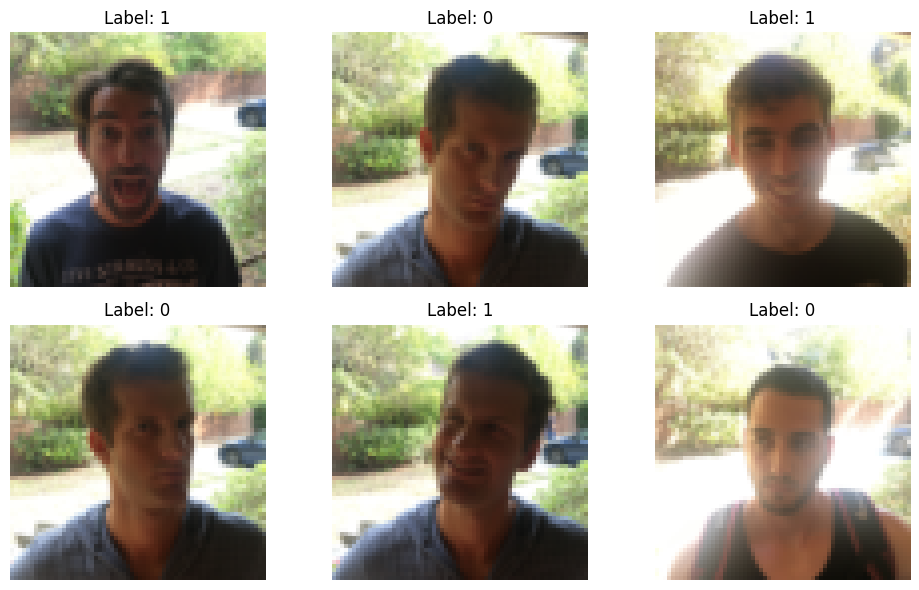

In [ ]:
# showing some images
import matplotlib.pyplot as plt
import random
indices = random.sample(range(x_train.shape[0]), 6)

# Set up the subplot grid
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for ax, idx in zip(axes.flatten(), indices):
    image = X_train[idx]
    label = Y_train[idx].item()

    ax.imshow(image)
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# standard size in pytorch (no.of channel,height,width)
# (no.of images,no.of channel,height,width)
class customdataset(Dataset):
  def __init__(self,image,label):
    self.image=torch.tensor(image).permute(0,3,1,2).float()
    self.label=torch.tensor(label,dtype=torch.long)

  def __len__(self):
    return self.image.shape[0]

  def __getitem__(self, index):
    return self.image[index],self.label[index]


# making obj
train_data=customdataset(x_train,y_train)
val_data=customdataset(x_val,y_val)
train_loader=DataLoader(train_data,batch_size=16,shuffle=True)
val_loader=DataLoader(val_data,batch_size=16,shuffle=False)

In [ ]:
 # ZEROPAD2D(3) -> CONV2D 32(7*7) -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.model=nn.Sequential(
        nn.ZeroPad2d(3), # after padding (3,64,64)-->(3,70,70)
        nn.Conv2d(in_channels=3,out_channels=32,kernel_size=7,stride=1,device=device),
        # after conv2d operation (3,70,70)-->(32,64,64)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),# (32,32,32)=32*32*32
        nn.Linear(out_features=1,in_features=32*32*32),
        nn.Sigmoid()
    )

  def forward(self,images):
    return self.model(images).squeeze(1)

In [ ]:
# making obj
model=CNN()
model=model.to(device)
model.state_dict()

OrderedDict([('model.1.weight',
              tensor([[[[ 8.9378e-03, -1.5500e-02,  4.8034e-02,  ..., -8.0165e-02,
                         -9.6619e-04,  7.1127e-02],
                        [ 2.7021e-02, -7.3039e-02, -2.6942e-02,  ...,  1.4739e-02,
                         -2.0520e-02, -2.4993e-02],
                        [-1.2799e-02,  1.9594e-02,  7.6031e-02,  ..., -1.2278e-02,
                         -1.6991e-02, -2.6414e-02],
                        ...,
                        [-4.7215e-02, -7.6119e-02, -7.5554e-02,  ...,  1.1904e-02,
                         -2.3646e-02,  4.4462e-02],
                        [ 5.7350e-02,  1.8890e-02, -4.2789e-02,  ...,  5.5232e-02,
                          7.3635e-02,  3.0820e-02],
                        [ 4.6268e-02,  6.0563e-02,  7.4501e-02,  ...,  6.2907e-02,
                         -2.8414e-02,  2.3542e-02]],
              
                       [[-2.9508e-02, -4.4098e-02, -7.6972e-02,  ...,  6.4172e-02,
                          5.45

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)

In [ ]:
model.apply(initialize_weights)

CNN(
  (model): Sequential(
    (0): ZeroPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=32768, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
model.state_dict()

OrderedDict([('model.1.weight',
              tensor([[[[ 1.3917e-02, -5.8123e-03,  1.9983e-02,  ..., -5.2055e-03,
                          9.6299e-03, -1.0927e-02],
                        [ 5.6461e-02, -1.4695e-02,  7.2482e-03,  ..., -4.9742e-02,
                         -7.6540e-02,  2.9689e-03],
                        [-2.5552e-02, -7.9711e-02,  4.6045e-03,  ...,  2.0863e-02,
                         -2.0037e-02,  2.2555e-02],
                        ...,
                        [-4.8336e-02,  2.0913e-02,  1.2970e-02,  ...,  5.5831e-02,
                         -6.0052e-03,  3.3877e-02],
                        [-1.8926e-02, -1.4407e-02, -4.1020e-02,  ..., -5.9873e-02,
                         -5.0454e-02,  1.6733e-02],
                        [-4.3196e-02,  5.6735e-02,  4.8914e-02,  ...,  1.6858e-04,
                          5.8434e-02, -1.5455e-02]],
              
                       [[-3.0369e-02, -4.3003e-02,  6.7039e-02,  ...,  4.6996e-02,
                          8.61

In [ ]:
# training
model.train()
epochs=100
learning_rate=0.01
loss_fxn=nn.BCELoss()
opt=optimizer.Adam(model.parameters(),lr=learning_rate)

for i in range(epochs):
  for batch,(batch_feature,batch_label) in enumerate(train_loader):
    batch_feature,batch_label=batch_feature.to(device),batch_label.to(device)
    # predection
    output=model(batch_feature)
    #loss
    loss=loss_fxn(output,batch_label.float())
    # clear gradient
    opt.zero_grad()
    # gradient
    loss.backward()
    #updation
    opt.step()


In [ ]:
model.eval()
training_loss = 0.0
validation_loss = 0.0
train_preds, train_labels = [], []
val_preds, val_labels = [], []

with torch.inference_mode():
    # ---- TRAINING SET ----
    for batch_feature, batch_label in train_loader:
        batch_feature, batch_label = batch_feature.to(device), batch_label.to(device)

        output = model(batch_feature)
        batch_label = batch_label

        loss = loss_fxn(output, batch_label.float())
        training_loss += loss.item()

        preds = (output >= 0.5).int().cpu().numpy()
        labels = batch_label.int().cpu().numpy()
        train_preds.extend(preds)
        train_labels.extend(labels)

    # ---- VALIDATION SET ----
    for batch_feature, batch_label in val_loader:
        batch_feature, batch_label = batch_feature.to(device), batch_label.to(device)

        output = model(batch_feature)
        batch_label = batch_label

        loss = loss_fxn(output, batch_label.float())
        validation_loss += loss.item()

        preds = (output >= 0.5).int().cpu().numpy()
        labels = batch_label.int().cpu().numpy()
        val_preds.extend(preds)
        val_labels.extend(labels)


In [ ]:
# Accuracy
train_acc = accuracy_score(train_labels, train_preds)
val_acc = accuracy_score(val_labels, val_preds)

# Avg Loss
avg_train_loss = training_loss / len(train_loader)
avg_val_loss = validation_loss / len(val_loader)

print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

Train Loss: 51.4583, Train Accuracy: 0.4854
Val Loss: 42.9688, Val Accuracy: 0.5583


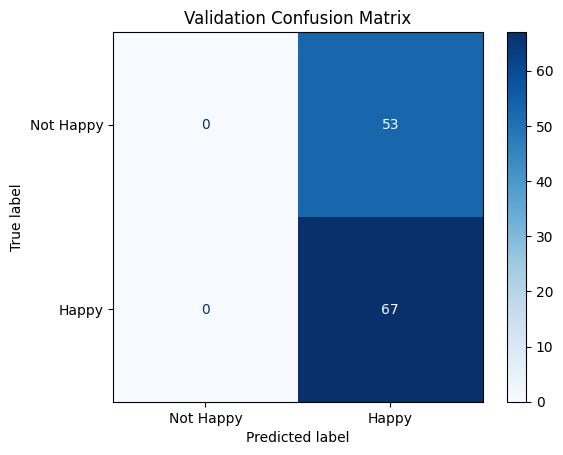

In [ ]:
cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Happy", "Happy"])
disp.plot(cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.show()